# Detecting Cancer in Gigapixel Pathology Images - Part 2

## COMS W4995 Applied Deep Learning

Pranav Alva pa2541

Megala Kannan msk2245

Link to YouTube video: https://youtu.be/U3qlaW_XpUQ


Installing Libraries

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras import optimizers

Function to download images from cloud

In [0]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

Downloading Slide Images

In [0]:
colab_root = "/content/" 
SLIDES_URL = "https://storage.googleapis.com/dsi_originals/slide_small.zip"

In [0]:
slides_file = os.path.join(colab_root, "slides.zip")
images_folder = os.path.join(colab_root, 'slides/')
download_if_missing(SLIDES_URL,
                    slides_file,
                    extract=False)

10554318848/10554312884 [==============================] - 230s 0us/step


'/content/slides.zip'

In [0]:
!7z x slides.zip

Splitting into Train and Test data

In [0]:
slide_paths = []
mask_paths = []

for file in os.listdir("/content/slide_small"):
  if file.endswith("mask.tif"):
    mask_paths.append(os.path.join("/content/slide_small", file))
  elif file.endswith(".tif"):
    slide_paths.append(os.path.join("/content/slide_small", file))

slide_paths.sort()
mask_paths.sort()

In [0]:
train_img = slide_paths[0:3]
test_img = slide_paths[3:8]
train_mask = mask_paths[0:3]
test_mask = mask_paths[3:8]

Function to Read Slide

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

Function to find tissue pixels and apply mask

In [0]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where((im_gray <= intensity) &(im_gray !=0))
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


Function of get evaluation metrics

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score

def eval_metrics(y_true, y_pred):
  intersection = np.logical_and(y_true, y_pred)
  union = np.logical_or(y_true, y_pred)
  iou_score = np.sum(intersection) / np.sum(union)

  CM = confusion_matrix(y_true, y_pred)
  TN = CM[0][0]
  FN = CM[1][0]
  TP = CM[1][1]
  FP = CM[0][1]
  
  sens = TP / (TP + FN)
  spec = TN / (TN + FP)
  return iou_score, sens, spec

Patch Extraction for Multiscale Model

In [0]:
# Function to extract identical patches from slide at 2 zoom levels

def extract_twin_patches_2_levels(slide_path, tumor_mask_path, zoom_level, stride_size, patch_size):
  '''
  Function:
  The fuctions extracts patches using the selected zoom level and identical pathes from the immediate numerically lower zoom level

  Inputs: 
  slide_path - path to the slide image from which to extract patches
  tumor_mask_path - path to the tumor mask corresponding to the slides
  zoom_level - upper zoom level (numerically greater)
  stride_size - inner patch size for selected zoom
  patch_size - full patch size for selected zoom

  Output:
  image_patches_z1 - list of patches at selected zoom level
  image_masks_z1 - list of corresponding masks
  image_patches_z2 - list of patches at numerically lower zoom level
  image_masks_z2 - list of corresponding masks
  '''

  ds_factor = 2**zoom_level
  offset = int((patch_size - stride_size)/2)
  zoom_level_1 = zoom_level - 1
  ds_factor_1 = 2**zoom_level_1
  stride_size_1 = int(stride_size * 2)
  patch_size_1 = int(patch_size * 2)
  offset_1 = int(offset * 2)

  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)

  for j in range(0,slide.level_dimensions[zoom_level_1][1],stride_size_1):
      for i in range(0,slide.level_dimensions[zoom_level_1][0], stride_size_1):
        patch_1 = read_slide(slide,
                            (i*ds_factor_1)-(offset_1*ds_factor_1),
                            (j*ds_factor_1)-(offset_1*ds_factor_1),
                            level = zoom_level_1,
                            width = patch_size_1,
                            height = patch_size_1) 
        mask_patch_1 = read_slide(tumor_mask,
                                (i*ds_factor_1)-(offset_1*ds_factor_1),
                                (j*ds_factor_1)-(offset_1*ds_factor_1),
                                level = zoom_level_1,
                                width = patch_size_1,
                                height = patch_size_1)
        patch_2 = read_slide(slide,
                            (int(i/2)*ds_factor)-(offset*ds_factor),
                            (int(j/2)*ds_factor)-(offset*ds_factor),
                            level = zoom_level,
                            width = patch_size,
                            height = patch_size)
        mask_patch_2 = read_slide(tumor_mask,
                                (int(i/2)*ds_factor)-(offset*ds_factor),
                                (int(j/2)*ds_factor)-(offset*ds_factor),
                                level = zoom_level,
                                width = patch_size,
                                height = patch_size)
        mask_patch_1 = mask_patch_1[:,:,0]
        mask_patch_2 = mask_patch_2[:,:,0]
        tissue_pixels = find_tissue_pixels(patch_1)
        tissue_pixels = list(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(patch_1.shape[0] * patch_1.shape[0]) * 100
        #print(percent_tissue)
        if percent_tissue > 20:
          image_patches_z1.append(patch_2)
          image_masks_z1.append(mask_patch_2)
          image_patches_z2.append(patch_1)
          image_masks_z2.append(mask_patch_1)

Patch Prediction and Slide Reconstruction

In [0]:
def predict_make_slide(model, slide_path, zoom_level, stride_size, patch_size):
  '''
  Function:
  The fuctions predicts on the test slide and constructs the predicted mask

  Inputs: 
  model - multiscale prediction model
  slide_path - path to the slide image from which to extract patches
  zoom_level - upper zoom level (numerically greater)
  stride_size - inner patch size for selected zoom
  patch_size - full patch size for selected zoom

  Output:
  pred_mask - predicted slide mask
  '''

  ds_factor = 2**zoom_level
  offset = int((patch_size - stride_size)/2)
  zoom_level_1 = zoom_level - 1
  ds_factor_1 = 2**zoom_level_1
  stride_size_1 = int(stride_size * 2)
  patch_size_1 = int(patch_size * 2)
  offset_1 = int(offset * 2)

  slide = open_slide(slide_path)
  
  pred_mask = np.full((slide.level_dimensions[zoom_level][1], slide.level_dimensions[zoom_level][0]), 0.0)

  for j in range(0,slide.level_dimensions[zoom_level_1][1],stride_size_1):
      for i in range(0,slide.level_dimensions[zoom_level_1][0], stride_size_1):
        patch_1 = read_slide(slide,
                            (i*ds_factor_1)-(offset_1*ds_factor_1),
                            (j*ds_factor_1)-(offset_1*ds_factor_1),
                            level = zoom_level_1,
                            width = patch_size_1,
                            height = patch_size_1) 
        patch_2 = read_slide(slide,
                            (int(i/2)*ds_factor)-(offset*ds_factor),
                            (int(j/2)*ds_factor)-(offset*ds_factor),
                            level = zoom_level,
                            width = patch_size,
                            height = patch_size)
        patch_1 = patch_1 / 255.
        patch_2 = patch_2 / 255.
        tissue_pixels = find_tissue_pixels(patch_1)
        tissue_pixels = list(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(patch_1.shape[0] * patch_1.shape[0]) * 100
        prediction = model_multiscale.predict([tf.expand_dims(patch_2,0),tf.expand_dims(patch_1,0)], steps =1)[0,0]
        if percent_tissue > 20:
          if (((i/2)+stride_size) > slide.level_dimensions[zoom_level][0]) and (((j/2)+stride_size) > slide.level_dimensions[zoom_level][1]):
            i_offset = int(slide.level_dimensions[zoom_level][0] - (i/2))
            j_offset = int(slide.level_dimensions[zoom_level][1] - (j/2))
            pred_mask[int(j/2):int(j/2)+j_offset,int(i/2):int(i/2)+i_offset] = np.full((j_offset, i_offset), prediction)
          
          elif (((i/2)+stride_size) > slide.level_dimensions[zoom_level][0]):
            i_offset = int(slide.level_dimensions[zoom_level][0] - (i/2))
            pred_mask[int(j/2):int(j/2)+stride_size,int(i/2):int(i/2)+i_offset] = np.full((stride_size, i_offset), prediction)
          
          elif (((j/2)+stride_size) > slide.level_dimensions[zoom_level][1]):
            j_offset = int(slide.level_dimensions[zoom_level][1] - (j/2))
            pred_mask[int(j/2):int(j/2)+j_offset,int(i/2):int(i/2)+stride_size] = np.full((j_offset, stride_size), prediction)
          
          else:
            pred_mask[int(j/2):int(j/2)+stride_size,int(i/2):int(i/2)+stride_size] = np.full((stride_size, stride_size), prediction)
        else:
          if (((i/2)+stride_size) > slide.level_dimensions[zoom_level][0]) and (((j/2)+stride_size) > slide.level_dimensions[zoom_level][1]):
            i_offset = int(slide.level_dimensions[zoom_level][0] - (i/2))
            j_offset = int(slide.level_dimensions[zoom_level][1] - (j/2))
            pred_mask[int(j/2):int(j/2)+j_offset,int(i/2):int(i/2)+i_offset] = np.full((j_offset, i_offset), 0.0)
          
          elif (((i/2)+stride_size) > slide.level_dimensions[zoom_level][0]):
            i_offset = int(slide.level_dimensions[zoom_level][0] - (i/2))
            pred_mask[int(j/2):int(j/2)+stride_size,int(i/2):int(i/2)+i_offset] = np.full((stride_size, i_offset), 0.0)
          
          elif (((j/2)+stride_size) > slide.level_dimensions[zoom_level][1]):
            j_offset = int(slide.level_dimensions[zoom_level][1] - (j/2))
            pred_mask[int(j/2):int(j/2)+j_offset,int(i/2):int(i/2)+stride_size] = np.full((j_offset, stride_size), 0.0)
          
          else:
            pred_mask[int(j/2):int(j/2)+stride_size,int(i/2):int(i/2)+stride_size] = np.full((stride_size, stride_size), 0.0)
  return pred_mask

Extraction patches at zoom level 4 with patch size 80x80 and area of center size 40x40

In [0]:
# Parameters
zoom_level = 4
stride_size = 40
patch_size = 80
offset = 20

In [0]:
image_patches_z1 = []
image_masks_z1 = []
image_patches_z2 = []
image_masks_z2 = []

for i in range(0,len(train_img)):
  extract_twin_patches_2_levels(train_img[i],train_mask[i],zoom_level,stride_size,patch_size)

Converting patches to Numpy nd arrays

In [0]:
image_patches_z1 = np.array(image_patches_z1)
image_masks_z1 = np.array(image_masks_z1)

In [0]:
image_patches_z2 = np.array(image_patches_z2)
image_masks_z2 = np.array(image_masks_z2) 

In [17]:
image_patches_z1.shape

(16861, 80, 80, 3)

In [18]:
image_patches_z2.shape

(16861, 160, 160, 3)

Plotting Image at both zoom levels

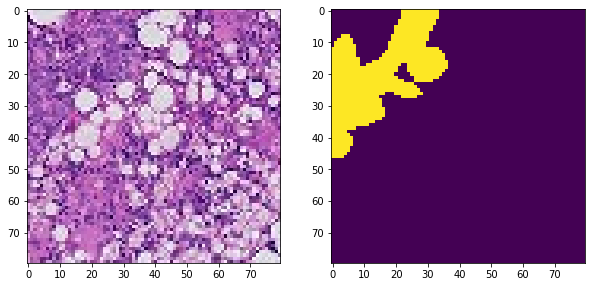

In [19]:
plt.figure(figsize= (10,5))
plt.subplot(1, 2, 1)
plt.imshow(image_patches_z1[469]) 
plt.subplot(1,2,2)
plt.imshow(image_masks_z1[469])

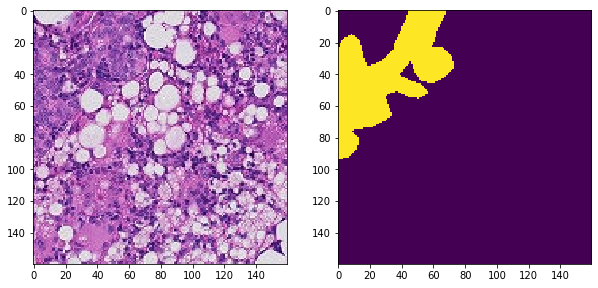

In [20]:
plt.figure(figsize= (10,5))
plt.subplot(1, 2, 1)
plt.imshow(image_patches_z2[469]) 
plt.subplot(1,2,2)
plt.imshow(image_masks_z2[469])

Assigning labels to the Patches

In [0]:
def assign_labels(image_masks):
  image_labels = []
  for mask in image_masks:
    if np.count_nonzero(mask[20:60,20:60]) > 0:
      image_labels.append(1)
    else :
      image_labels.append(0)
  image_labels = np.array(image_labels)
  return image_labels

In [0]:
image_labels_z1 = assign_labels(image_masks_z1)
image_labels_z2 = assign_labels(image_masks_z2)

Handling the class imbalance

In [0]:
def class_balanced(image_patches, image_labels):
  class0 = np.where(image_labels==0)[0]
  class1= np.where(image_labels==1)[0]
  class1_upsampled = np.random.choice(class1, size = len(class0), replace= True)
  assert(len(class1_upsampled)==len(class0))
  
  image_patches_0 = list(image_patches[class0])
  image_patches_1= list(image_patches[class1_upsampled])
  for array in image_patches_1:
    image_patches_0.append(array)
  image_patches = np.array(image_patches_0)

  image_labels_0 = list(image_labels[class0])
  image_labels_1= list(image_labels[class1_upsampled])
  for array in image_labels_1:
    image_labels_0.append(array)
  image_labels = np.array(image_labels_0)
  return image_patches, image_labels

In [0]:
image_patches_bal_z1, image_labels_bal_z1 = class_balanced(image_patches_z1, image_labels_z1)
image_patches_bal_z2, image_labels_bal_z2 = class_balanced(image_patches_z2, image_labels_z1)

Splitting Data in Training and Validation Splits

In [0]:
import sklearn
from sklearn.model_selection import train_test_split
X_train_z1, X_val_z1, y_train_z1, y_val_z1 = train_test_split(image_patches_bal_z1, image_labels_bal_z1, 
                                                    test_size=0.3,stratify = image_labels_bal_z1,random_state = 42)


In [0]:
X_train_z2, X_val_z2, y_train_z2, y_val_z2 = train_test_split(image_patches_bal_z2, image_labels_bal_z1, 
                                                    test_size=0.3,stratify = image_labels_bal_z1,random_state = 42)

Freeing Memory

In [0]:
del image_patches_z1
del image_labels_z1
del image_masks_z1
del image_patches_z2
del image_masks_z2
del image_patches_bal_z1
del image_patches_bal_z2
del image_labels_bal_z1
del image_labels_bal_z2

Stadardizing data, normalizing and defining batches

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale= 1./255)
val_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow([X_train_z1, X_train_z2], y_train_z1, batch_size=32, shuffle=True)
val_generator = val_datagen.flow([X_val_z1, X_val_z2], y_val_z1, batch_size=32, shuffle=True)

Multiscale Model Definition

In [0]:
input_1 = Input(shape=(80, 80, 3))

x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_1)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)

input_2 = Input(shape=(160, 160, 3))

y = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_2)
y = Conv2D(16, (3, 3), padding='valid', activation='relu')(y)
y = MaxPool2D(pool_size=(2,2), strides=(2,2))(y)
y = Conv2D(32, (3, 3), padding='valid', activation='relu')(y)
y = Conv2D(32, (3, 3), padding='valid', activation='relu')(y)
y = MaxPool2D(pool_size=(2,2), strides=(2,2))(y)
y = Conv2D(128, (3, 3), padding='valid', activation='relu')(y)
y = Conv2D(128, (3, 3), padding='valid', activation='relu')(y)
y = MaxPool2D(pool_size=(2,2), strides=(2,2))(y)
y = Flatten()(y)
y = Dense(256, activation='relu')(y)
y = Dropout(rate=0.2)(y)
y = Dense(128, activation='relu')(y)
y = Dropout(rate=0.2)(y)

merged = tf.keras.layers.concatenate([x,y])

output = Dense(1, activation = 'sigmoid')(merged)

model_multiscale = Model(inputs=[input_1, input_2], outputs=output)

In [44]:
model_multiscale.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 78, 78, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 158, 158, 16) 448         input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
from tensorflow.keras import optimizers

adam = optimizers.Adam(lr=1e-4)
model_multiscale.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Fitting the Model on the Training Data and Validating

In [46]:
history = model_multiscale.fit_generator(train_generator,
                              steps_per_epoch = len(X_train_z1) //32,
                              epochs = 5,
                              validation_data = val_generator)

Epoch 1/5
585/585 [==============================] - 26s 45ms/step - loss: 0.4165 - acc: 0.8496 - val_loss: 0.1252 - val_acc: 0.9507
Epoch 2/5
585/585 [==============================] - 25s 42ms/step - loss: 0.1271 - acc: 0.9539 - val_loss: 0.0772 - val_acc: 0.9787
Epoch 3/5
585/585 [==============================] - 25s 42ms/step - loss: 0.0774 - acc: 0.9741 - val_loss: 0.0557 - val_acc: 0.9827
Epoch 4/5
585/585 [==============================] - 24s 42ms/step - loss: 0.0438 - acc: 0.9849 - val_loss: 0.1888 - val_acc: 0.9381
Epoch 5/5
585/585 [==============================] - 24s 42ms/step - loss: 0.0341 - acc: 0.9895 - val_loss: 0.0323 - val_acc: 0.9908


Contructing the Predicted Mask on Test Image

In [0]:
pred_mask = predict_make_slide(model_multiscale,test_img[0],zoom_level,stride_size, patch_size)

In [0]:
img = test_img[0]
img_mask = test_mask[0]
slide = open_slide(img)
tumor_mask = open_slide(img_mask)

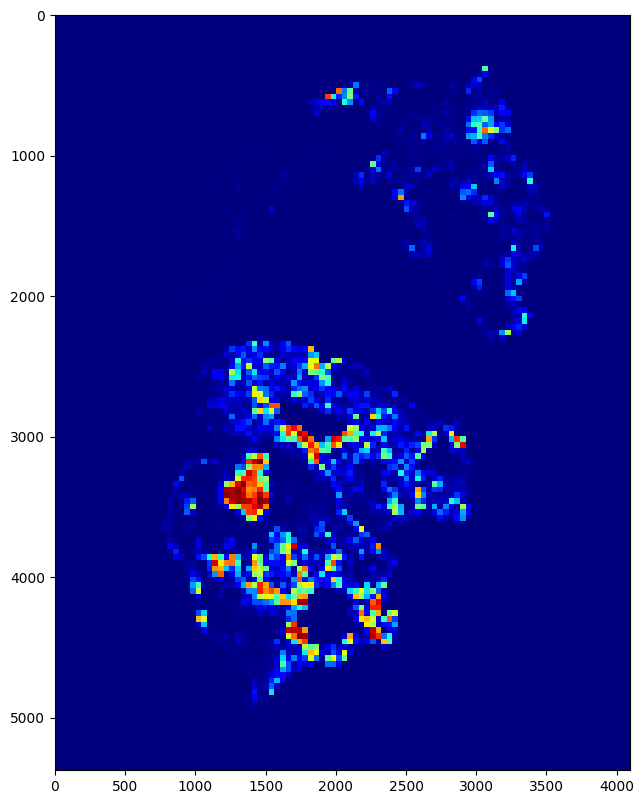

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(pred_mask_aug, cmap = 'jet')
plt.savefig('custom_pred1')

In [0]:
y_true = mask_image.flatten()
y_pred = pred_mask_aug.flatten()

In [0]:
rec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred > i, 1, 0)
  rec_list.append(recall_score(y_true,new_pred))

In [0]:
print(np.linspace(0.1,0.5,8))

[0.1        0.15714286 0.21428571 0.27142857 0.32857143 0.38571429
 0.44285714 0.5       ]


In [0]:
rec_list

[0.8272212785609732,
 0.7729603218711106,
 0.7322646043537138,
 0.7019482908424851,
 0.6675068295852152,
 0.6675068295852152,
 0.5735599164011804,
 0.5551415622333722]

In [0]:
prec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred > i, 1, 0)
  prec_list.append(precision_score(y_true,new_pred))

In [0]:
prec_list

[0.07779740871613663,
 0.09843301435406698,
 0.1162388170974155,
 0.1353804347826087,
 0.1514133522727273,
 0.1665546875,
 0.16961574074074073,
 0.19356168122270742]

In [0]:
#using probability threshold 0.328
y_pred_new = np.where(y_pred > 0.328, 1, 0)

In [0]:
iou, sens, spec = eval_metrics(y_true, y_pred_new)

In [0]:
print(iou)

0.14079451588883182


In [0]:
print(spec)

0.9781693535497776


In [0]:
print(classification_report(y_true, y_pred_new, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99  21892343
     class 1       0.15      0.67      0.25    127753

    accuracy                           0.98  22020096
   macro avg       0.57      0.82      0.62  22020096
weighted avg       0.99      0.98      0.98  22020096



In [0]:
pred_mask_new = np.where(pred_mask_aug > 0.328 , 1, 0)

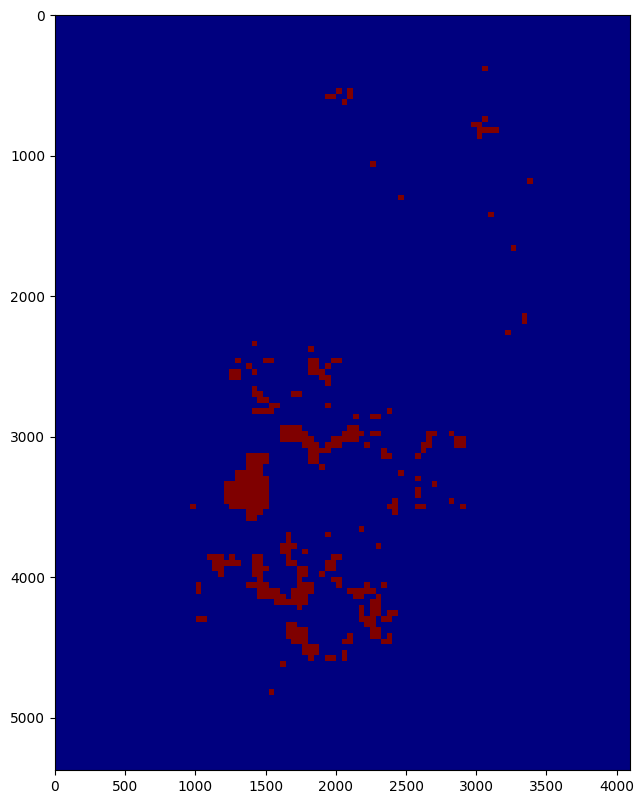

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(pred_mask_new, cmap = 'jet')

Saving Model

In [53]:
from tensorflow import saved_model
saved_model.save(model_multiscale, "/content/custom_multiscale")

INFO:tensorflow:Assets written to: /content/custom_multiscale/assets
